In [1]:
import numpy as np

In [13]:
# define default coefficients
v= 0.25    # drift term
lbg=0.1    # Specific algal maintenance respiration losses
mumax=1.2  # Maximum specific algal production rate
rhomax=0.2 # Maximum specific algal nutrient uptake rate
qmax=0.04  # Maximum algal nutrient quota
qmin=0.004 # Minimum algal nutrient quota 
m=1.5      # Half-saturation constant of algal nutrient uptake
h=120.0    # Half-saturation constant of light-dependent algal production
I0 = 300   # Light intensity at the surface 
kbg=0.4    # Background light-attenuation coefficient - change to 0.02 to see some oscillations? Originally 0.4
r = 0.02   # Specific mineralization rate of sedimented nutrients

def rnorm(mu,sigma,z):
    """create normal hump around mu over z, of std. dev. sigma"""
    return np.exp( -(z-mu)**2/(2*sigma**2) )/ np.sqrt(2*np.pi*sigma**2)

def I(z,A,I_0=I0,k = 0.0003):
    """Function to plot I using array A[:,i], default k=0.0003, larger values of k make effect of A on I more apparent"""
    integral = np.zeros(len(z))
    integral[1:] = np.cumsum(k*A[1:]) 
    return I_0 * np.exp( - integral- kbg*z)

def p(I,q):
    return mumax * (1.0 - qmin/q) * (I/(h + I))

def rho(q, Rd):
    return rhomax * (qmax-q)/(qmax-qmin) * ( Rd/(m + Rd) )

In [14]:
def next_step(z,A, Rb, Rd, Rs,dz,dt,d,I_0=I0):
    """Calculates next step for input arrays of length zmax"""
    
    II = I(z,A,I_0=I_0)
    q = Rb[1:-1]/A[1:-1]
    pp = p(II[1:-1],q)
    rrho = rho(q,Rd[1:-1])
    
    A_next = np.zeros(len(A))
    Rb_next = np.zeros(len(Rb))
    Rd_next = np.zeros(len(Rd))
    
    A_drift = v * (A[2:]-A[:-2]) / (2*dz)
    A_diffusion = d * (A[2:]-2*A[1:-1] + A[:-2]) / (dz**2)
    Rb_drift = v * (Rb[2:]-Rb[:-2]) / (2*dz)
    Rb_diffusion = d * (Rb[2:]-2*Rb[1:-1] + Rb[:-2]) / (dz**2)
    Rd_diffusion = d * (Rd[2:]-2*Rd[1:-1] + Rd[:-2]) / (dz**2)
    
    A_next[1:-1] = A[1:-1] + dt * ( pp*A[1:-1] -lbg*A[1:-1] - A_drift + A_diffusion )
    A_next[0] = 4*d/(2*v*dz + 3*d)*A_next[1] - d/(2*v*dz + 3*d)*A_next[2] 
    A_next[-1] = (4*A_next[-2] - A_next[-3])/3
    
    Rb_next[1:-1] = Rb[1:-1] + dt * (rrho*A[1:-1] -lbg*Rb[1:-1] - Rb_drift + Rb_diffusion )
    Rb_next[0] = 4*d/(2*v*dz + 3*d)*Rb_next[1] - d/(2*v*dz + 3*d)*Rb_next[2] 
    Rb_next[-1] = (4*Rb_next[-2] - Rb_next[-3])/3
    
    Rs_next = Rs + dt*(v*Rb[-1] - r*Rs)
    
    Rd_next[1:-1] = Rd[1:-1] + dt*(lbg*Rb[1:-1] -rrho*A[1:-1] + Rd_diffusion)
    Rd_next[0] = (4*Rd_next[1] - Rd_next[2])/3 
    Rd_next[-1] = (2*r*dz*Rs_next + 4*d*Rd_next[-2] - d*Rd_next[-3])/(3*d)
    
    
    return A_next, Rb_next, Rd_next, Rs_next
    


In [31]:
def get_light_shift(zmax=30.0, tmax=100.0, d=1.0, I0=300.0, light_shift=0.6):
    """ A, Rb, Rd, Rs, z_grid, time_steps, Nz, Nt = get_light_shift(zmax=30.0, tmax=100.0, d=1.0, I0=300.0, light_shift=0.6) 
    light_shift such that shift occurs at light_shift*tmax"""
    
    dz = 0.1 ## change to 0.02 or ok?
    dt = dz/1000 # temporary 
    Nz = int(zmax/dz)
    Nt = int(tmax/ (1000*dt) )

    z_grid = np.arange(0,zmax,dz)
    time_steps = np.arange(0,tmax,dt)
    
    shift_loc = int(0.6*len(time_steps))

    A_0 = 100 
    Rb_0 = 2.2
    Rd_0 = 30 
    Rs_0 = 0
    
    A = np.zeros((Nz,Nt)) # RESULTS MATRIX: rows: deeper z-values, cols: time steps forward
    A[:,0] = A_0 * np.ones(Nz) # creates homogenous initial conditions
    Rb = np.zeros((Nz,Nt))
    Rb[:,0] = Rb_0 * np.ones(Nz)
    Rd = np.zeros((Nz,Nt))
    Rd[:,0] = Rd_0 * np.ones(Nz)
    Rs = np.zeros(Nt)
    A_next,Rb_next,Rd_next, Rs_next = A[:,0], Rb[:,0], Rd[:,0], Rs[0] #initial conditions

    i = 1
    counter = 1
    for t in time_steps[:shift_loc]:
        
        A_next, Rb_next, Rd_next, Rs_next = next_step(z_grid, A_next, Rb_next, Rd_next, Rs_next, dz,dt,d)
        
        if ( i % 1000 == 0):
            A[:,counter],Rb[:,counter],Rd[:,counter],Rs[counter] = A_next,Rb_next,Rd_next,Rs_next
            counter = counter +1
            
        i = i+1
        
    for t in time_steps[shift_loc:-1]:
        
        A_next, Rb_next, Rd_next, Rs_next = next_step(z_grid, A_next, Rb_next, Rd_next, Rs_next, dz,dt,d,I_0=I0*2)
        
        if ( i % 1000 == 0):
            A[:,counter],Rb[:,counter],Rd[:,counter],Rs[counter] = A_next,Rb_next,Rd_next,Rs_next
            counter = counter +1
            
        i = i+1
        
    return A, Rb, Rd, Rs, z_grid, time_steps, Nz, Nt
    

In [32]:
A, Rb, Rd, Rs, z_grid, time_steps, Nz, Nt = get_light_shift(zmax=30.0, tmax=100.0, d=1.0, I0=300.0, light_shift=0.6)

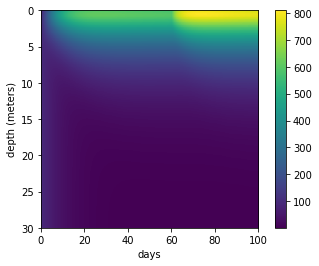

In [33]:
tmax = 100
zmax = 30
import matplotlib.pyplot as plt
# Heatmap
plt.imshow(A[:,:],aspect=tmax/zmax,origin="lower",extent=(0,tmax,0,zmax))
plt.xlabel('days')
plt.ylabel('depth (meters)')
plt.gca().invert_yaxis()
plt.colorbar()

Text(0.5, 0.92, 'A - Phytoplankton')

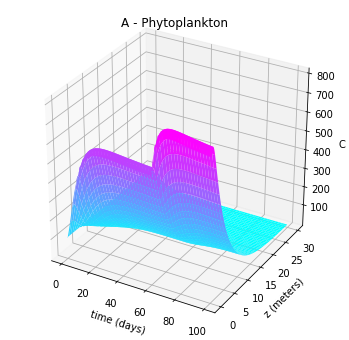

In [34]:
# 3D Visualize
from mpl_toolkits.mplot3d import axes3d
#T,Z = np.meshgrid(time_steps,z_grid)
#%matplotlib notebook
days = np.linspace(0,tmax,Nt)
T,Z = np.meshgrid(days,z_grid)

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(T,Z, A, cmap='cool')
ax.set_xlabel('time (days)')
ax.set_ylabel('z (meters)')
ax.set_zlabel('C')
ax.set_title('A - Phytoplankton')

In [35]:
A, Rb, Rd, Rs, z_grid, time_steps, Nz, Nt = get_light_shift(zmax=30.0, tmax=200.0, d=1.0, I0=300.0, light_shift=0.6)

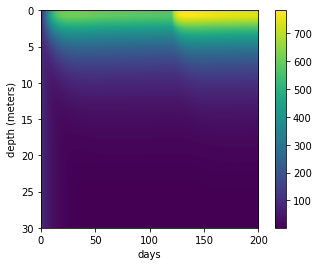

In [36]:
tmax = 200
zmax = 30
import matplotlib.pyplot as plt
# Heatmap
plt.imshow(A[:,:],aspect=tmax/zmax,origin="lower",extent=(0,tmax,0,zmax))
plt.xlabel('days')
plt.ylabel('depth (meters)')
plt.gca().invert_yaxis()
plt.colorbar()

Text(0.5, 0.92, 'A - Phytoplankton')

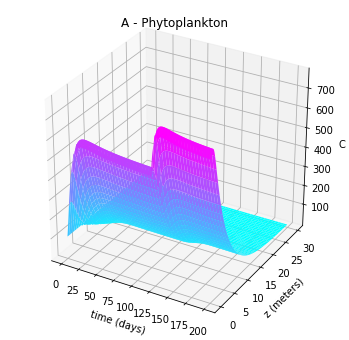

In [37]:
# 3D Visualize
from mpl_toolkits.mplot3d import axes3d
#T,Z = np.meshgrid(time_steps,z_grid)
#%matplotlib notebook
days = np.linspace(0,tmax,Nt)
T,Z = np.meshgrid(days,z_grid)

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(T,Z, A, cmap='cool')
ax.set_xlabel('time (days)')
ax.set_ylabel('z (meters)')
ax.set_zlabel('C')
ax.set_title('A - Phytoplankton')

### create sine plot for seasonality? 
Sine function like, I0 = 300 for some period of time and zero for other and smooth curve between them, get some temperate climate figures and an equation if possible (?)